In [161]:
import numpy as np 
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.cm as cm
import tensorflow as tf

### Load data

In [162]:
direc = Path('data/Fish_Dataset/Fish_Dataset')
filepaths = list(direc.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))

filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)

img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

#Resampling it
img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

FilePaths      Labels
0  data/Fish_Dataset/Fish_Dataset/Trout/Trout/009...       Trout
1  data/Fish_Dataset/Fish_Dataset/Red Mullet/Red ...  Red Mullet
2  data/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/0...      Shrimp
3  data/Fish_Dataset/Fish_Dataset/Red Mullet/Red ...  Red Mullet
4  data/Fish_Dataset/Fish_Dataset/Shrimp/Shrimp/0...      Shrimp

### Display first 9 images as a test

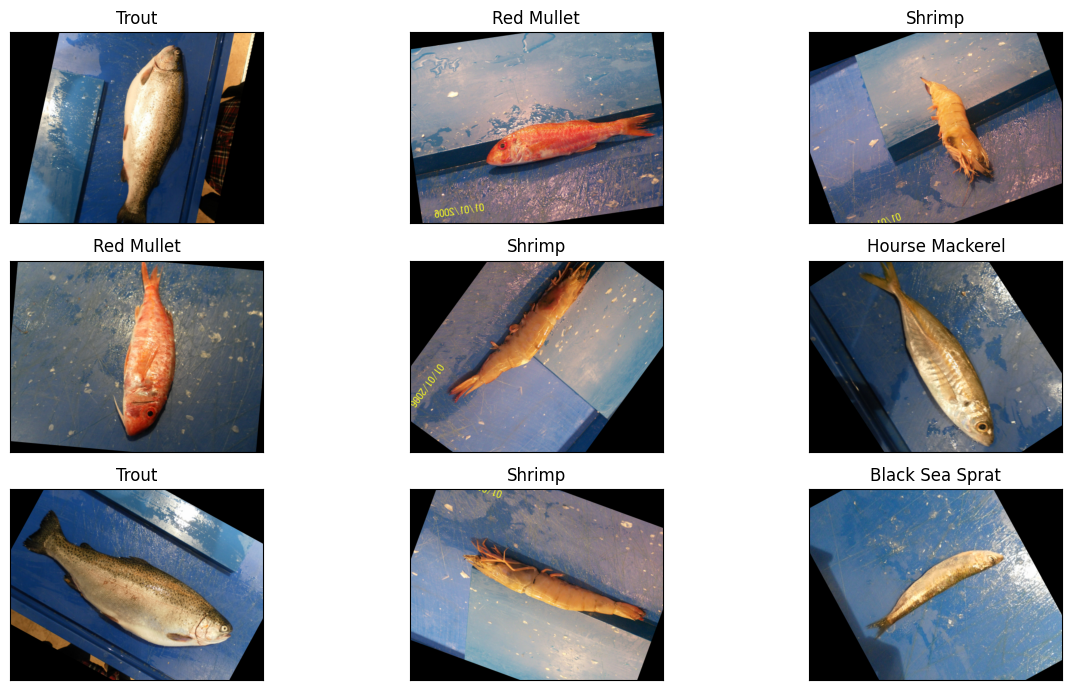

In [163]:
# Showing 9Images 
import matplotlib.pyplot as plt

f,a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])
    
plt.tight_layout()
plt.show()

### Shape of dataframe

In [164]:
print(f" Count of Rows : {img_df.shape[0]} \n Count of Columns : {img_df.shape[1]} ")

 Count of Rows : 9000 
 Count of Columns : 2 


### Types of fish

In [165]:
img_df['Labels'].value_counts(ascending=True)

Trout                 1000
Red Mullet            1000
Shrimp                1000
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Striped Red Mullet    1000
Name: Labels, dtype: int64

### Splitting the data

In [166]:
train_ratio = 0.75
validation_ratio = 0.10
test_ratio = 0.15

# Splitting the data into train, test and validation
x_train, x_test = train_test_split(img_df, test_size=1 - train_ratio)
x_val, x_test = train_test_split(x_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(f'Shape of Training Data : ',x_train.shape)
print(f'Shape of Testing Data : ',x_test.shape)
print(f'Shape of Validation Data : ',x_val.shape)
x_testt = x_test.copy()

Shape of Training Data :  (6750, 2)
Shape of Testing Data :  (1350, 2)
Shape of Validation Data :  (900, 2)


### Augmenating The Data

In [167]:
img_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

img_size=(224, 224)    

x_train = img_datagen.flow_from_dataframe(dataframe = x_train, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_test = img_datagen.flow_from_dataframe(dataframe = x_test, x_col='FilePaths', y_col='Labels', target_size=img_size,color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_val = img_datagen.flow_from_dataframe(dataframe = x_val, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)

Found 6750 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [168]:
image_dir = Path('data/Fish_Dataset/Fish_Dataset')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Drop GT images
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(3)

# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 6480 validated image filenames belonging to 9 classes.
Found 1620 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


### Creating The Model

In [147]:
fc_model = tf.keras.models.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Flatten(input_shape=(224,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(9,activation="softmax")
])

fc_model.compile(optimizer="Adam",
             loss="categorical_crossentropy",
             metrics=["accuracy"])

### Training the model

In [148]:
#Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
mo_fit = fc_model.fit(x_train,
                validation_data = x_val,
                epochs = 30)
                #callbacks=Callback),

Epoch 1/30
211/211 [==============================] - 64s 300ms/step - loss: 1.5962 - accuracy: 0.3960 - val_loss: 1.0242 - val_accuracy: 0.6433
Epoch 2/30
211/211 [==============================] - 62s 294ms/step - loss: 1.0016 - accuracy: 0.6393 - val_loss: 0.6866 - val_accuracy: 0.7411
Epoch 3/30
211/211 [==============================] - 63s 298ms/step - loss: 0.7089 - accuracy: 0.7406 - val_loss: 0.5499 - val_accuracy: 0.8100
Epoch 4/30
211/211 [==============================] - 63s 300ms/step - loss: 0.5034 - accuracy: 0.8244 - val_loss: 0.3298 - val_accuracy: 0.8856
Epoch 5/30
211/211 [==============================] - 62s 294ms/step - loss: 0.3961 - accuracy: 0.8590 - val_loss: 0.3288 - val_accuracy: 0.8922
Epoch 6/30
211/211 [==============================] - 63s 299ms/step - loss: 0.3176 - accuracy: 0.8919 - val_loss: 0.2694 - val_accuracy: 0.9100
Epoch 7/30
211/211 [==============================] - 62s 294ms/step - loss: 0.2767 - accuracy: 0.9044 - val_loss: 0.2272 - val_ac

### Model summary

In [151]:
print('Model summary :')
print()
fc_model.summary()

Model summary :

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, None, None, None)  0         
                                                                 
 flatten_6 (Flatten)         (None, None)              0         
                                                                 
 dense_38 (Dense)            (None, 128)               19267712  
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_39 (Dense)            (None, 128)               16512     
                                                                 
 dense_40 (Dense)            (None, 128)               16512     
                                                                 
 dropout_14 (Dropout)        (None, 1

In [152]:
test_accuracy = fc_model.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )

43/43 [==============================] - 11s 251ms/step - loss: 0.1564 - accuracy: 0.9511
Test accuracy is :  95.11111378669739 %


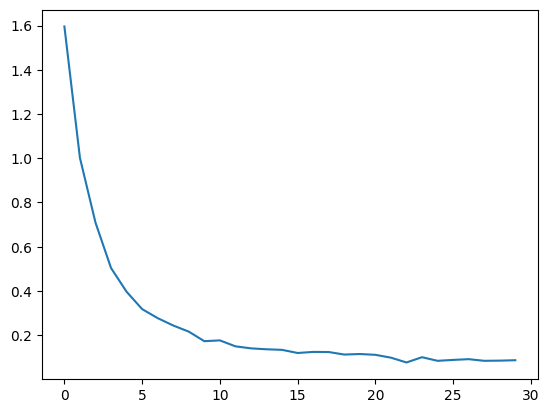

In [154]:
accuracy = mo_fit.history['accuracy']
loss = mo_fit.history['loss']
validation_loss = mo_fit.history['val_loss']
validation_accuracy = mo_fit.history['val_accuracy']

plt.plot([i for i in range(30)], mo_fit.history['loss'])

Text(0.5, 1.0, 'Accuracy : Training Vs Validation ')

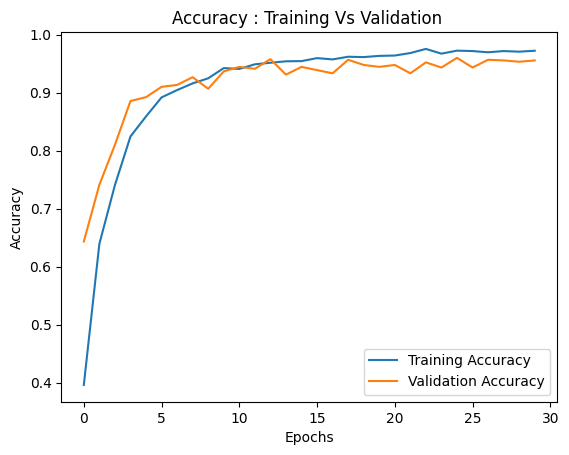

In [155]:
plt.plot(range(30), accuracy, label='Training Accuracy')
plt.plot(range(30), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy : Training Vs Validation ')

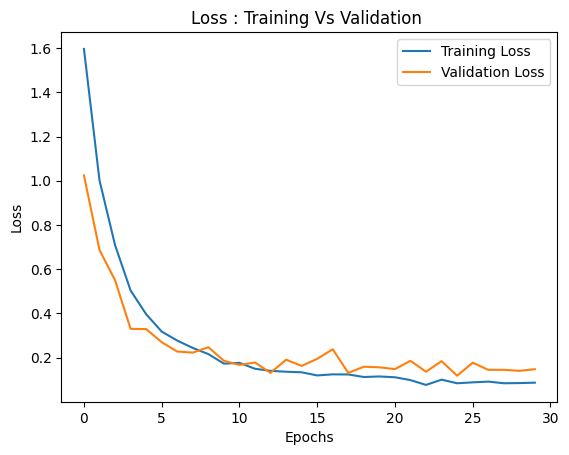

In [156]:
plt.plot(range(30), loss, label='Training Loss')
plt.plot(range(30), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [139]:
# Predict the label of the test_images
pred = fc_model.predict(test_images)
pred = np.argmax(pred,axis=1)

29/29 [==============================] - 7s 242ms/step


In [140]:
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Red Sea Bream', 'Trout', 'Hourse Mackerel', 'Gilt-Head Bream', 'Sea Bass']


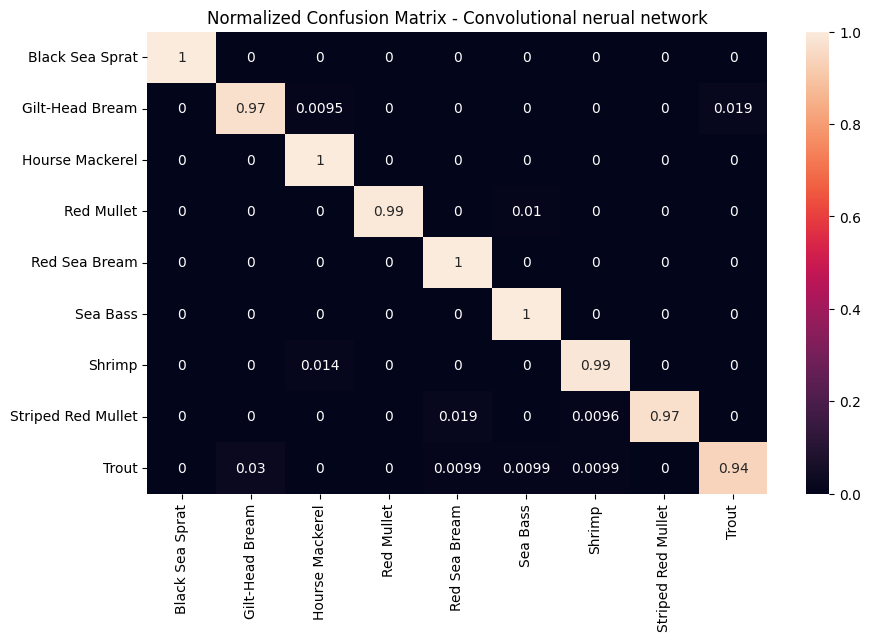

In [149]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix - Convolutional nerual network')
plt.show()

### Using a pretrained model

In [38]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

### Traning pretrained model

In [39]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=1,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
203/203 [==============================] - 78s 375ms/step - loss: 0.1566 - accuracy: 0.9559 - val_loss: 0.0153 - val_accuracy: 0.9951
Epoch 2/50
203/203 [==============================] - 76s 375ms/step - loss: 0.0118 - accuracy: 0.9974 - val_loss: 0.0138 - val_accuracy: 0.9957
Epoch 3/50
203/203 [==============================] - 78s 382ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 0.0033 - val_accuracy: 0.9994
Epoch 4/50
203/203 [==============================] - 77s 377ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0040 - val_accuracy: 0.9988


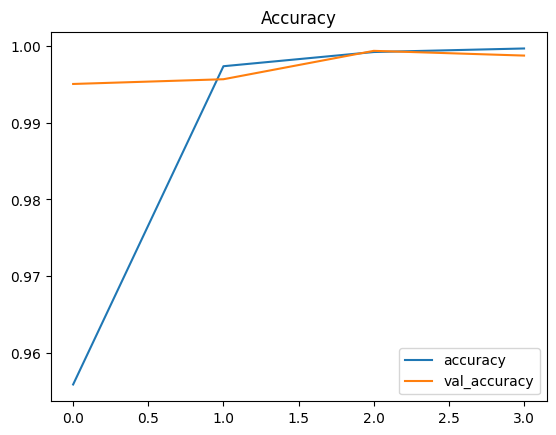

In [42]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

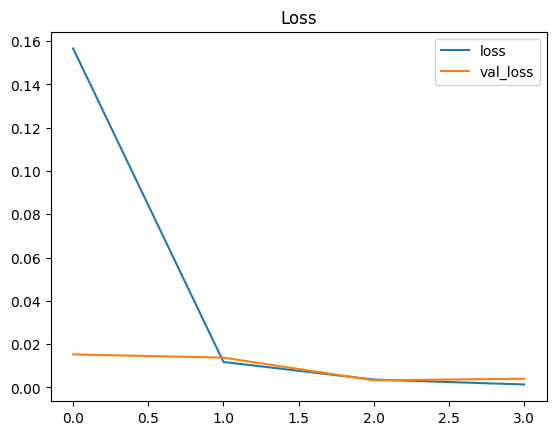

In [43]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

### Visualize the result

In [171]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00209
Test Accuracy: 99.89%


In [158]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

29/29 [==============================] - 9s 295ms/step
The first 5 predictions: ['Red Sea Bream', 'Trout', 'Hourse Mackerel', 'Gilt-Head Bream', 'Sea Bass']


In [159]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                    precision    recall  f1-score   support

   Black Sea Sprat       0.99      1.00      1.00       104
   Gilt-Head Bream       1.00      1.00      1.00       105
   Hourse Mackerel       1.00      1.00      1.00       106
        Red Mullet       1.00      1.00      1.00       100
     Red Sea Bream       1.00      1.00      1.00        93
          Sea Bass       1.00      0.99      1.00       113
            Shrimp       1.00      1.00      1.00        74
Striped Red Mullet       1.00      1.00      1.00       104
             Trout       1.00      1.00      1.00       101

          accuracy                           1.00       900
         macro avg       1.00      1.00      1.00       900
      weighted avg       1.00      1.00      1.00       900



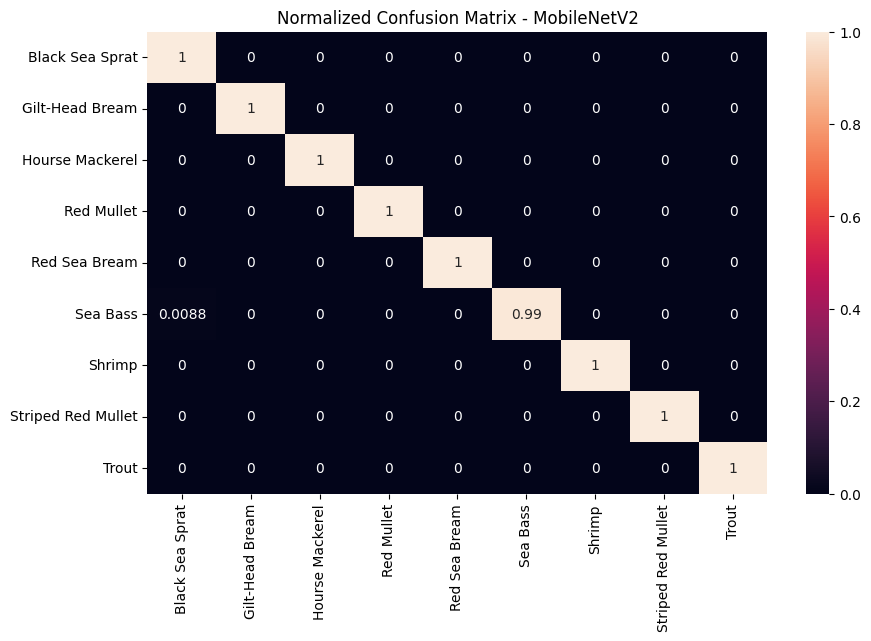

In [160]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix - MobileNetV2')
plt.show()

### Examples of prediction

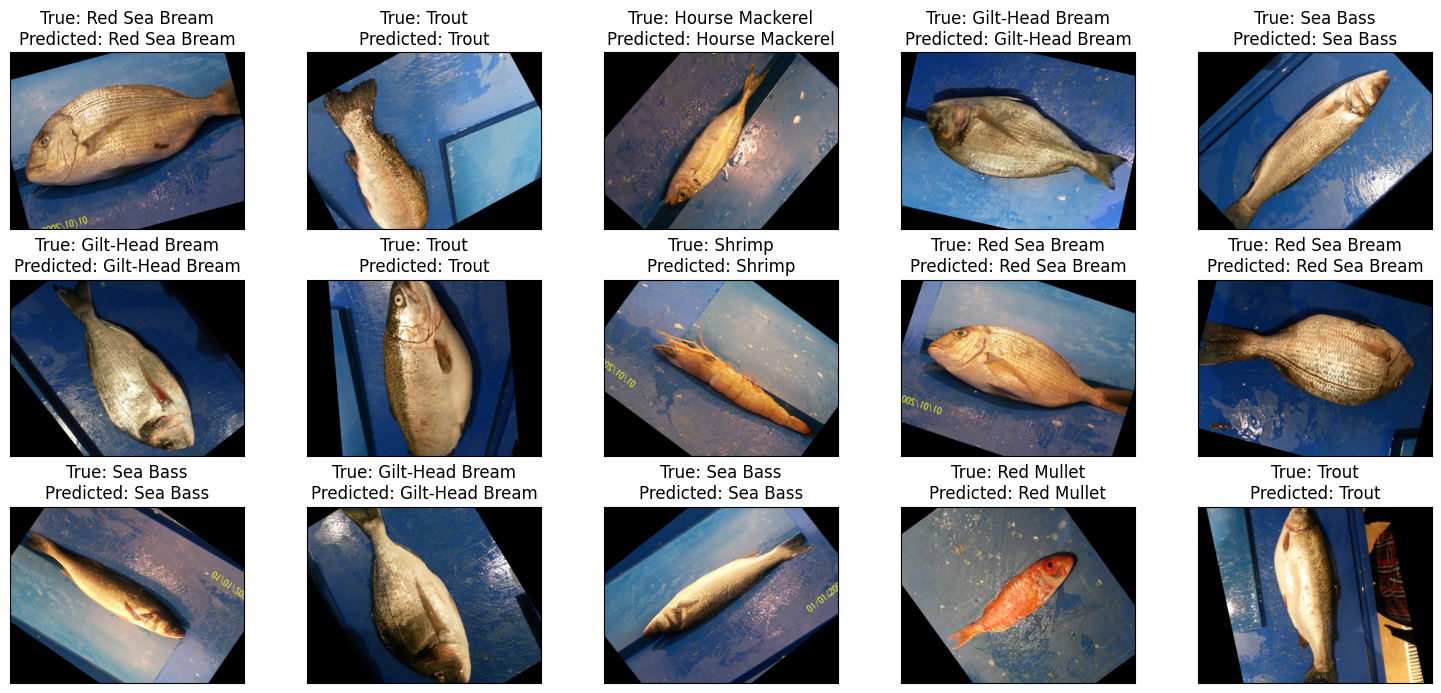

In [48]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

### Activation heatmap

In [52]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)
    return cam_path
    
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].activation = None

/var/folders/18/27kk04gn68z8t3bc0npl90x00000gn/T/ipykernel_18593/1394198541.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


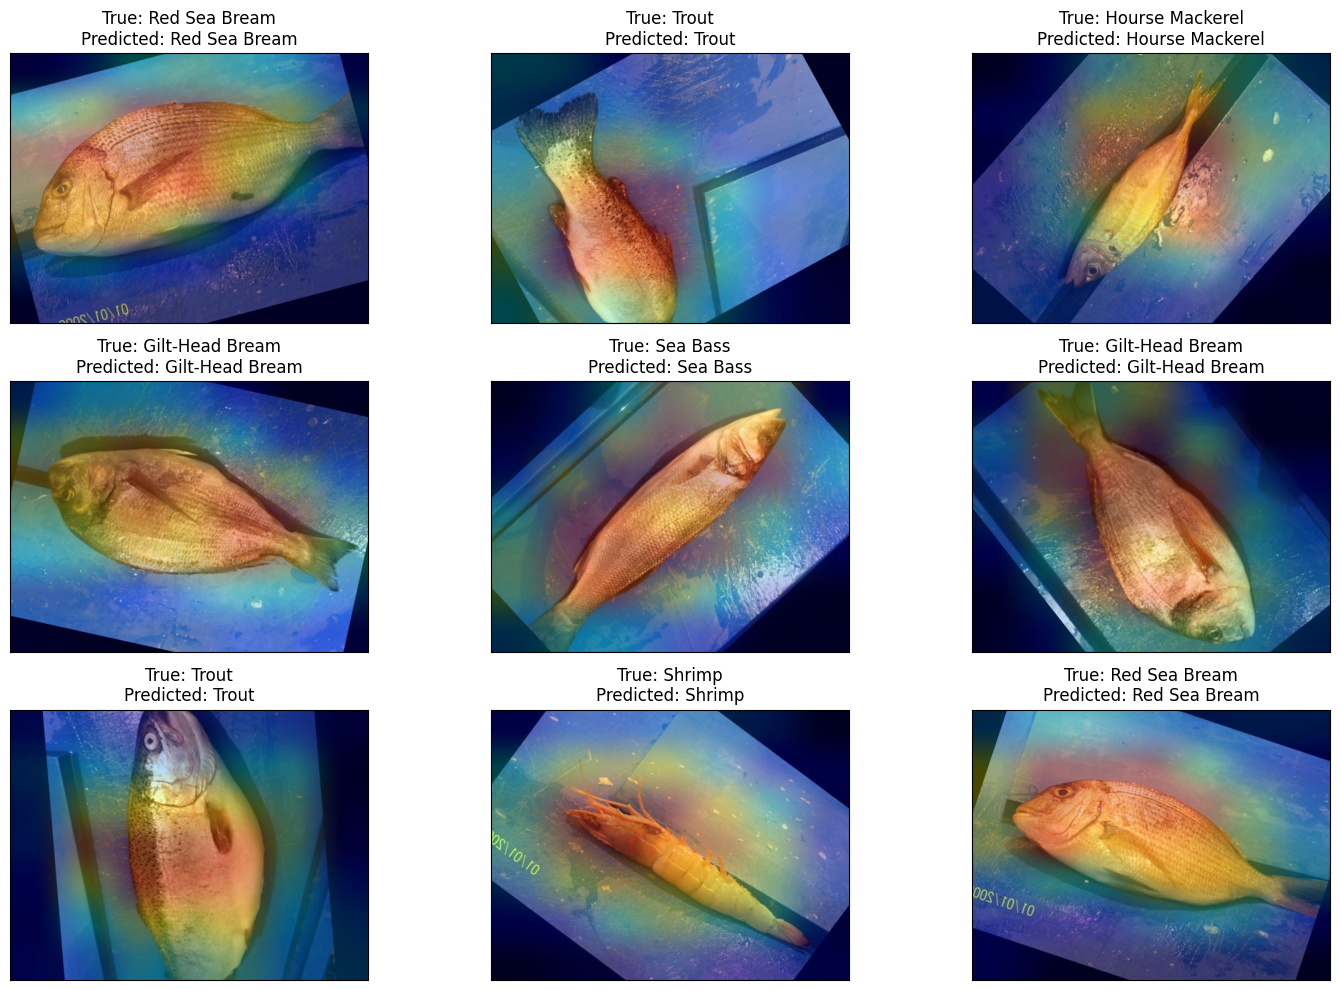

In [55]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()